# New York City Taxi Analysis
---

### Introduction

This notebook shows you how we can use exploratory data analysis and machine learning for predicting breast cancers. All our models are built using  New York City Taxi dataset.


Also, based on the data in this dataset, we would like to suggest following projects which create valuable business opportunities for **NYC Taxi and Limousine Commission** (**TLC**).

1. Intelligent Cab Positioning: position cabs where they are most needed, how many taxis to dispatch, and how ridership varies over time. 
2.  Predicting the Number of Taxi Pickups: given a one-hour time window and a location within New York City
3. Real-time Allocation Suggestion for Drivers: Based on the past data available to us, we can create a model which can suggest most profitable areas for cab drivers to pick customers.
4. Predicting Travel Time for Each Taxi Ride: This helps TLC to dispatch cabs to different locations in the city. In addition to that this information helps the customer to plan their travels as well.

In this node book, we are going to analyze item number four (i.e. **Predicting Travel Time for Each Taxi Ride**)


### Loading Necessary Tools (Python/Numpy, Pandas, Scikit-Learn, LGBM, and etc.) 

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale

sns.set()

print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Light Gradient Booting version: {}'.format(lgb.__version__))

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Numpy version: 1.13.3
Pandas version: 0.20.3
Light Gradient Booting version: 2.1.0


### Loading the Dataset

Next, we are going to load the dataset as a Pandas data frame (DataFrame). In ML model building, it is the best practice to keep the testing dataset aside and it should not be mixed with training dataset. So as the very first step, we split our dataset into training and testing subsets.

We are going to use **80 percent** (i.e. **8000 data rows**) of the dataset for training and the rest (i.e. **2000 data rows**) for testing. 

In [2]:
data = pd.read_csv('./data/yellow_tripdata_2016-01_10000rows.csv')
data = data.sample(n=len(data))

train_size = int(len(data)*0.8)
test_size = len(data) - train_size

assert len(data) == (train_size + test_size)
print('training dataset size: {}'.format(train_size))
print('testing dataset size: {}'.format(test_size))

train = data.iloc[0:train_size]
test = data.iloc[train_size:]

assert len(data) == len(train) + len(test)

training dataset size: 8000
testing dataset size: 2000


As you know real-world datasets come with missing values  (or measurements). So, first of all, we need to check this dataset contains null or missing values. If it has missing values, proper data imputation techniques need to be applied.

I'm going to use **Panda's** **`isnull()`** for testing null/missing values.

In [3]:
assert train.isnull().values.any() == False
assert test.isnull().values.any() == False

Great, this dataset doesn't have any missing values so we don't need to use data imputation techniques. If it contains missing values I might be using one or more following techniques.

1. **Impute missing values with mean**: Usually, this is suitable for numerical features.
2. **Impute missing values with median**: This approach is more appropriate for categorical features.
3. **EM algorithm based approaches**: Bit advanced but very useful tool for missing value imputation.

### Create Response Variable

In this analysis, we are going to predict taxi trip duration using available data. So we create our response variable using **tpep_pickup_datetime** and **tpep_dropoff_datetime**.

In [4]:
from datetime import datetime

fmt = '%m/%d/%Y %H:%M'

def calculate_trip_duration(row):
    start = datetime.strptime(row['tpep_pickup_datetime'], fmt)
    end = datetime.strptime(row['tpep_dropoff_datetime'], fmt)
    return (end - start).seconds / 60.0

train['trip_time'] = train.apply(calculate_trip_duration, axis=1)
test['trip_time'] = test.apply(calculate_trip_duration, axis=1)

### Exploratory Data Analysis and Visualization

Exploratory data analysis helps us to understand the nature of the training dataset. Also, it is a great tool to understand the relationships between different features of the dataset.

#### Distribution of  Response Variable (Taxi Trip Duration)

As the first step of our exploratory data analysis, we plot the distribution of taxi trip durations measured in minutes. 

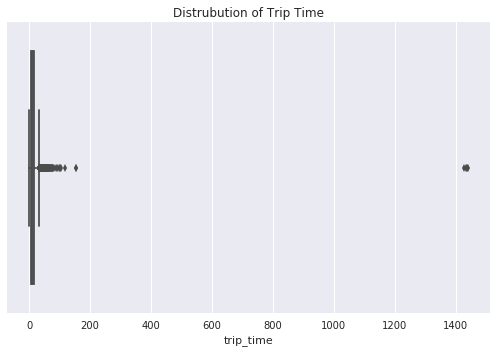

In [5]:
f, axes = plt.subplots(1, 1)
f.set_size_inches(7, 5)

sns.boxplot(train['trip_time']).set_title("Distrubution of Trip Time")
plt.tight_layout()
plt.show()

Above graph clearly shows we have few **outliers**. So let's remove those and redraw the graph again. 

In [6]:
train = train.drop(train[train.trip_time > 120].index)
test = test.drop(test[test.trip_time > 120].index)

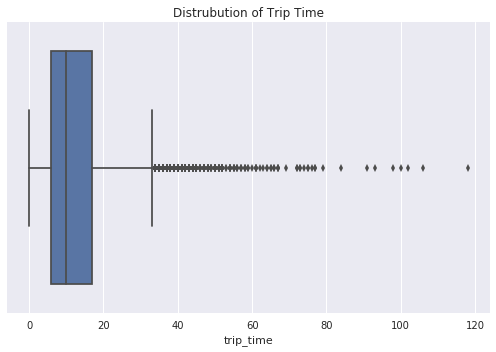

In [7]:
f, axes = plt.subplots(1, 1)
f.set_size_inches(7, 5)

#sns.boxplot(test['trip_time'])
sns.boxplot(train['trip_time']).set_title("Distrubution of Trip Time")
plt.tight_layout()
plt.show()

Now response variables look OK.

#### Various Plots to Identify Good Features and Relationship Between Features

We can use the following three plots to identify quality (in terms of predictive power) features for our model building process. Also, it is worth to note that, for real-world projects, we might use a lot more plots and visualizations than we presented in this notebook.

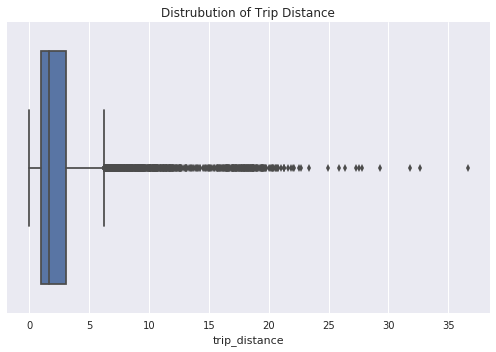

In [8]:
f, axes = plt.subplots(1, 1)
f.set_size_inches(7, 5)

sns.boxplot(train['trip_distance']).set_title("Distrubution of Trip Distance")
plt.tight_layout()
plt.show()

#### Scatter Plots: Pickup and Dropoff Points

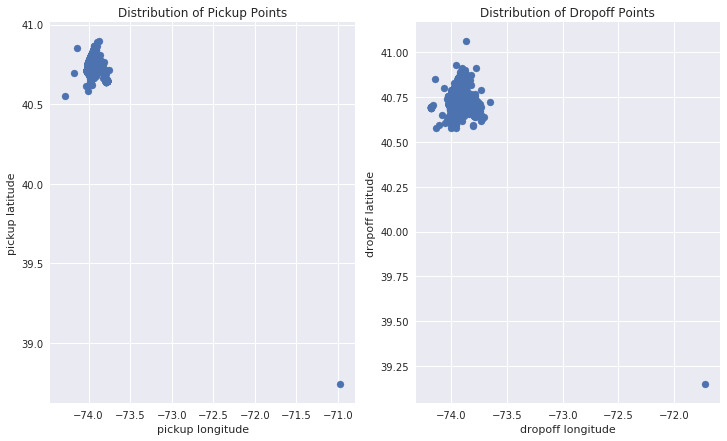

In [9]:
f, axes = plt.subplots(1, 2)
f.set_size_inches(12, 7)
axes[0].scatter(train.pickup_longitude, train.pickup_latitude)
axes[0].set(title='Distribution of Pickup Points', 
            xlabel='pickup longitude', ylabel='pickup latitude')

axes[1].scatter(train.dropoff_longitude, train.dropoff_latitude)
axes[1].set(title='Distribution of Dropoff Points', 
            xlabel='dropoff longitude', ylabel='dropoff latitude')

plt.show()

So it looks like we have few **outliers** based on the longitude and altitude data. So let's further clean our dataset.  

In [10]:
cond_1 = (train.dropoff_longitude > -73.5) 
cond_2 = (train.dropoff_latitude < 40.5 )
train = train.drop(train[cond_1 & cond_2].index)
#test = test.drop(test[cond_1 & cond_2].index)

cond_3 = (train.dropoff_longitude > -73.5) 
cond_4 = (train.dropoff_latitude < 40.5 )
train = train.drop(train[cond_3 & cond_4].index)
#test = test.drop(test[cond_1 & cond_2].index)

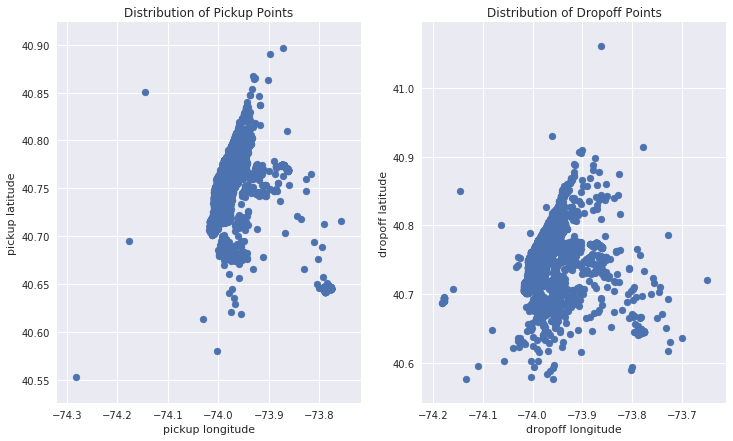

In [11]:
f, axes = plt.subplots(1, 2)
f.set_size_inches(12, 7)
axes[0].scatter(train.pickup_longitude, train.pickup_latitude)
axes[0].set(title='Distribution of Pickup Points', 
            xlabel='pickup longitude', ylabel='pickup latitude')

axes[1].scatter(train.dropoff_longitude, train.dropoff_latitude)
axes[1].set(title='Distribution of Dropoff Points', 
            xlabel='dropoff longitude', ylabel='dropoff latitude')

plt.show()

Great, now data looks OK in terms of longitudes and altitudes 

#### The relationship between Longitude/Latitude vs Trip Time.

We use following **regression plots** to check the relationship between our response variable and longitudes/latitudes. 

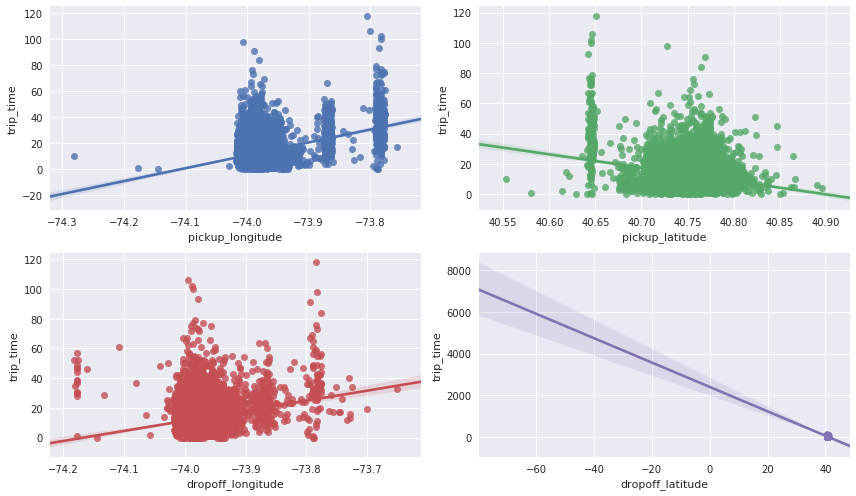

In [12]:
independent = ['pickup_longitude', 'pickup_latitude', 
               'dropoff_longitude', 'dropoff_latitude']
dependents =  ['trip_time']

f, axes = plt.subplots(2, 2)
f.set_size_inches(12, 7)

for i in range(len(independent)):
    sns.regplot(x=independent[i], y=dependents[0], 
                data=train, ax=axes[i//2, i%2])

plt.tight_layout()
plt.show()

OK, it looks like there is **no apparent relationship** between these two tri time and longitudes/latitudes. So  I'm going to engineer some features out of longitudes and latitudes.

In [13]:
AVG_EARTH_RADIUS = 6371  # in km

def haversine(point1, point2, miles=False):
    """ Calculate the great-circle distance between two points on the Earth surface.
    :input: two 2-tuples, containing the latitude and longitude of each point
    in decimal degrees.
    Example: haversine((45.7597, 4.8422), (48.8567, 2.3508))
    :output: Returns the distance bewteen the two points.
    The default unit is kilometers. Miles can be returned
    if the ``miles`` parameter is set to True.
    """

    # Unpack latitude/longitude
    lat1, lng1 = point1
    lat2, lng2 = point2

    # Convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

    # Calculate haversine
    lat, lng= lat2 - lat1, lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h * 0.621371 if miles else h # in m/km

def dummy_manhattan_distance(point1, point2):
    lat1, lng1 = point1
    lat2, lng2 = point2
    a = haversine((lat1, lng1), (lat1, lng2))
    b = haversine((lat1, lng1), (lat2, lng1))

    return haversine((lat1, lng1), (lat1, lng2)) + haversine((lat1, lng1), (lat2, lng1))

In [14]:
# apply calculated distances to both training and tesing 
# data sets.

# training
train['distance_haversine'] = haversine(
    (train['pickup_latitude'].values, train['pickup_longitude'].values),
    (train['dropoff_latitude'].values, train['dropoff_longitude'].values)
)

train['distance_dummy_manhattan'] = dummy_manhattan_distance(
    (train['pickup_latitude'].values, train['pickup_longitude'].values),
    (train['dropoff_latitude'].values, train['dropoff_longitude'].values)
)

# testing 
test['distance_haversine'] = haversine(
    (test['pickup_latitude'].values, test['pickup_longitude'].values),
    (test['dropoff_latitude'].values, test['dropoff_longitude'].values)
)

test['distance_dummy_manhattan'] = dummy_manhattan_distance(
    (test['pickup_latitude'].values, test['pickup_longitude'].values),
    (test['dropoff_latitude'].values, test['dropoff_longitude'].values)
)

In the following graph, I'm testing my new features against the predictive variable i.e. **trip time**.

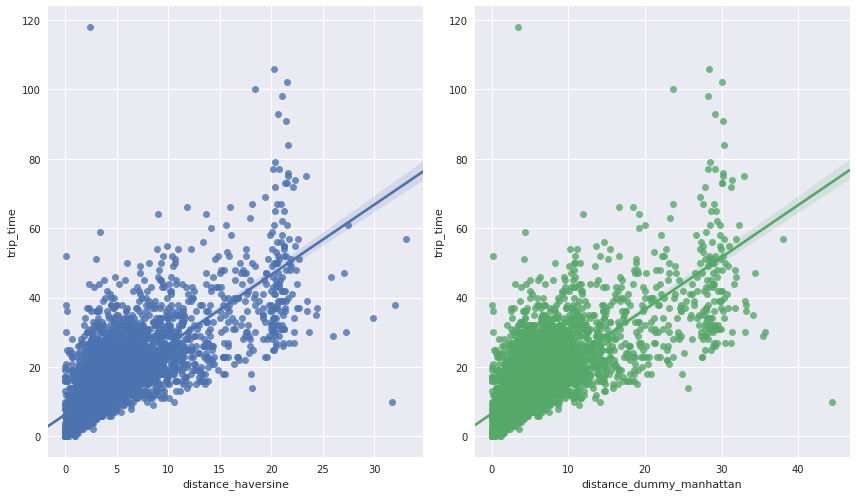

In [15]:
independent = ['distance_haversine', 'distance_dummy_manhattan']
dependents =  ['trip_time']

f, axes = plt.subplots(1, 2)
f.set_size_inches(12, 7)

for i in range(len(independent)):
    sns.regplot(x=independent[i], 
                y=dependents[0], data=train, ax=axes[i])

plt.tight_layout()
plt.show()

Great, now we have engineered **two features** which can be **really useful** when it comes to **model building**.  

Additionally, we are going to create several more features as described below.

All these features are based on **`tpep_pickup_datetime`**. So first of all, let's convert **`tpep_pickup_datetime`** to a **`datetime`** series. 

In [16]:
train['pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

Now, I'm going to create features such as **pickup_weekday**, **pickup_hour**, **night_trip**, and etc.

In [17]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_am'] = train['pickup_hour'] < 12
train['night_trip'] = [True if x < 7 else False for x in train['pickup_hour']]
train['rush_hour'] = [True if 9 < x < 20 else False for x in train['pickup_hour']]
train['weekday'] = [True if x < 5 else False for x in train['pickup_weekday']]

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_am'] = test['pickup_hour'] < 12
test['night_trip'] = [True if x < 7 else False for x in test['pickup_hour']]
test['rush_hour'] = [True if 9 < x < 20 else False for x in test['pickup_hour']]
test['weekday'] = [True if x < 5 else False for x in test['pickup_weekday']]

Now let's plot some of these **new features** against our **response variable**.

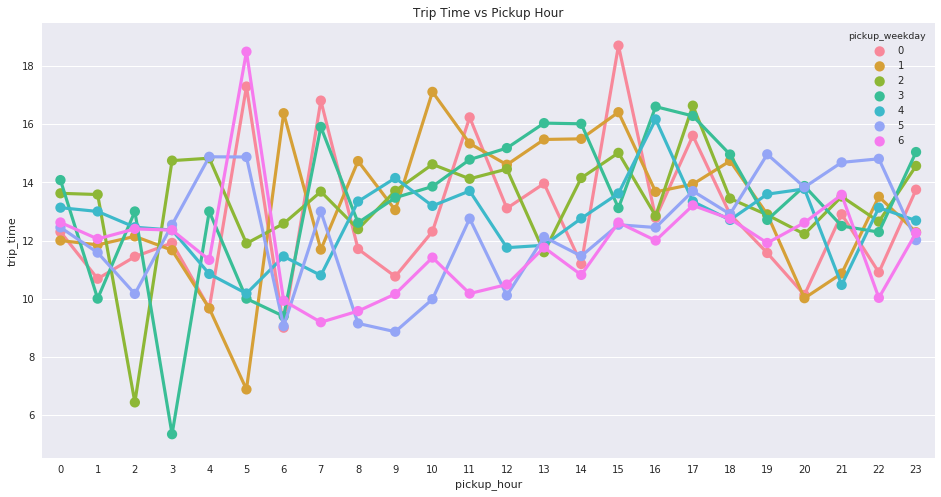

In [18]:
import calendar

f, axes = plt.subplots(1, 1)
f.set_size_inches(16, 8)
sns.pointplot(x='pickup_hour',y='trip_time',data=train,
             hue='pickup_weekday', ci=None).set_title('Trip Time vs Pickup Hour')

plt.show()

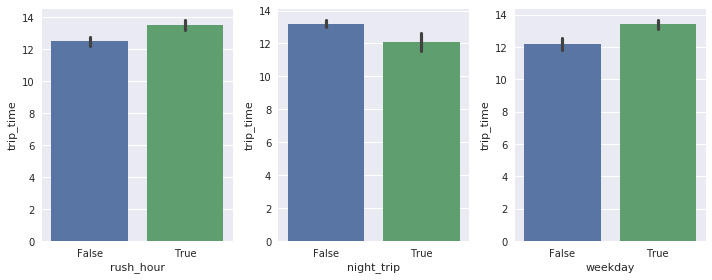

In [19]:
independent = ['rush_hour', 'night_trip', 'weekday']
dependents =  ['trip_time']

f, axes = plt.subplots(1, 3)
f.set_size_inches(10, 4)

for i in range(len(independent)):
    sns.barplot(x=independent[i], y=dependents[0], data=train, ax=axes[i])

plt.tight_layout()
plt.show()

According to above plots, it is obvious that these generated features might be good as features when it comes to building our models.


**Note**: We just plotted a couple of graphs only. But in practice, it is worth to check the relationship between all possible feature combinations.

### Machine Learning Model Building

Now its time to build some machine learning models. We will start with simple models with few features. But as we progress through the model building process we will explore more advanced models as well.

#### Linear Regression

As the initial step, we will create a Linear Regression model just using **trip_distance** only. So this model will work as our baseline model. 

Also, it is worth to note that, we are using **`5-Fold`**  cross-validation and **`root mean squared error`** as our evaluation metric.  

In [20]:
%%time
X_train = train[['trip_distance']].values
y_train = train['trip_time'].values

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_simple = LinearRegression()
    lr_simple.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_simple.predict(scale(X_test_cv))
    current_accuracy = np.sqrt(mean_squared_error(y_test_cv, y_predict_cv))
    cv_accuracies.append(current_accuracy)
    print('root mean squared error: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average root mean squared error: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

root mean squared error: 6.900316
root mean squared error: 5.819575
root mean squared error: 6.157454
root mean squared error: 6.215310
root mean squared error: 6.356792
---------------------------------------
average root mean squared error: 6.289889
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.5 ms


Well, as the very starting model, the result looks  OK. But, let's add few more features and look the predictive power of our model.

So I'm going to use following numerical and categorical features. All categorical variables will be converted to **one-hot** vectors using **`pd.get_dummies`** method.

In [21]:
X_train  = pd.concat([train[['trip_distance', 'distance_haversine', 'distance_dummy_manhattan']],
                      pd.get_dummies(train[['pickup_weekday']]),
                      pd.get_dummies(train[['rush_hour']]),
                      pd.get_dummies(train[['weekday']]),
                      pd.get_dummies(train[['night_trip']]),
                      pd.get_dummies(train[['pickup_day']]),
                      pd.get_dummies(train[['payment_type']]),], axis=1).values

In [22]:
%%time
kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_simple = LinearRegression()
    lr_simple.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_simple.predict(scale(X_test_cv))
    current_accuracy = np.sqrt(mean_squared_error(y_test_cv, y_predict_cv))
    cv_accuracies.append(current_accuracy)
    print('root mean squared error: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average root mean squared error: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

root mean squared error: 6.660572
root mean squared error: 5.508912
root mean squared error: 5.826733
root mean squared error: 6.007021
root mean squared error: 6.188478
---------------------------------------
average root mean squared error: 6.038343
CPU times: user 62.5 ms, sys: 15.6 ms, total: 78.1 ms
Wall time: 31.3 ms


OK, we can see some improvement, unfortunately, that is not significant. So next, I'm going to use few more ML models to check whether I can further improve **`RMSE`**.

#### Random Forest

In [23]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_simple = RandomForestRegressor(n_estimators=500, max_depth=7)
    lr_simple.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_simple.predict(scale(X_test_cv))
    current_accuracy = np.sqrt(mean_squared_error(y_test_cv, y_predict_cv))
    cv_accuracies.append(current_accuracy)
    print('root mean squared error: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average root mean squared error: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

root mean squared error: 6.174489
root mean squared error: 4.831369
root mean squared error: 5.257222
root mean squared error: 5.061424
root mean squared error: 5.296813
---------------------------------------
average root mean squared error: 5.324263
CPU times: user 23 s, sys: 62.5 ms, total: 23.1 s
Wall time: 23.2 s


#### Light Gradient Booting Regression

In [24]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_simple = lgb.LGBMRegressor(n_estimators=150)
    lr_simple.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_simple.predict(scale(X_test_cv))
    current_accuracy = np.sqrt(mean_squared_error(y_test_cv, y_predict_cv))
    cv_accuracies.append(current_accuracy)
    print('root mean squared error: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average root mean squared error: %f' %(sum(cv_accuracies)/len(cv_accuracies)))


root mean squared error: 6.341569
root mean squared error: 4.978701
root mean squared error: 5.184082
root mean squared error: 5.152810
root mean squared error: 5.246211
---------------------------------------
average root mean squared error: 5.380675
CPU times: user 2.52 s, sys: 141 ms, total: 2.66 s
Wall time: 705 ms


In [25]:
%%time

from sklearn.grid_search import GridSearchCV
from sklearn.metrics.scorer import make_scorer

def MSE(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #print('MSE: %2.3f' % rmse)
    return rmse

my_scorer = make_scorer(MSE, greater_is_better=False)

cls = RandomForestRegressor()

param_grid = {
    'bootstrap': [True],
    'max_depth': [7, 13,],
    'max_features': [2],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [50, 100, 250, 500, 1000, 2500]
}

gs = GridSearchCV(estimator=cls, param_grid=param_grid, 
                  cv=5, n_jobs=8, scoring=my_scorer, verbose = 0)
gs.fit(X_train, y_train)

CPU times: user 5.72 s, sys: 422 ms, total: 6.14 s
Wall time: 1min 27s


In [27]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=1024)

cv_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    lr_simple = gs.best_estimator_
    lr_simple.fit(scale(X_train_cv), y_train_cv)
    y_predict_cv = lr_simple.predict(scale(X_test_cv))
    current_accuracy = np.sqrt(mean_squared_error(y_test_cv, y_predict_cv))
    cv_accuracies.append(current_accuracy)
    print('root mean squared error: %f' %(current_accuracy))
    
print ('---------------------------------------')
print ('average root mean squared error: %f' %(sum(cv_accuracies)/len(cv_accuracies)))

root mean squared error: 6.099472
root mean squared error: 4.627820
root mean squared error: 5.080690
root mean squared error: 5.005876
root mean squared error: 5.265919
---------------------------------------
average root mean squared error: 5.215955
CPU times: user 21.1 s, sys: 31.2 ms, total: 21.1 s
Wall time: 21.2 s
